<a href="https://colab.research.google.com/github/EBarbara/Deep-Biometrics/blob/master/Deep_Biometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from glob import glob
import pandas as pd
from scipy.io.arff import loadarff
In this notebook, we improve on our intermediate neural net by applying the theory we've covered since.

Install Dependencies

In [ ]:
!pip install arff 
!pip install scipy==1.7.1

  Created wheel for arff: filename=arff-0.9-py3-none-any.whl size=4971 sha256=f0c9f209803ef05e10fa8fed39dd4c5049796e9c1866752020099d2e556bc00b
  Stored in directory: /root/.cache/pip/wheels/fe/81/bd/4ae90e24ba860304e375da219f9205b2586dbee255f3ee70e2
Successfully built arff
     |████████████████████████████████| 28.5 MB 11.1 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip freeze

Load Dependencies

In [ ]:
import numpy as np
import pandas as pd

from glob import glob
from scipy.io.arff import loadarff

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import (
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GRU,
    LSTM,
    MaxPooling1D,
    SimpleRNN,
)

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.optimizers import SGD

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load and read dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get a list of all the csv files
arf_files = glob('/content/drive/MyDrive/Deep Learning/wisdm/*.arff')

dfs = pd.concat((pd.DataFrame(loadarff(file)[0]) for file in arf_files))
# List comprehension that loads of all the files

# List comprehension that looks at the shape of all DataFrames
print(dfs)
print(len(dfs.index))

    "ACTIVITY"   "X0"   "X1"   "X2"  ...   "XZCOR"   "YZCOR"  "RESULTANT"  "class"
0         b'A'  0.205  0.130  0.300  ...  0.252518  0.102834     11.44030  b'1603'
1         b'A'  0.210  0.135  0.325  ...  0.396639  0.163752     11.20960  b'1603'
2         b'A'  0.195  0.185  0.225  ...  0.462766  0.097135     11.53580  b'1603'
3         b'A'  0.210  0.155  0.255  ...  0.387476  0.177059     11.58630  b'1603'
4         b'A'  0.205  0.185  0.205  ...  0.406013  0.151663     11.89350  b'1603'
..         ...    ...    ...    ...  ...       ...       ...          ...      ...
322       b'S'  0.035  0.420  0.500  ... -0.187801  0.238269      2.02908  b'1647'
323       b'S'  0.065  0.475  0.400  ... -0.296492 -0.157986      1.97007  b'1647'
324       b'S'  0.100  0.385  0.385  ... -0.304941 -0.014148      2.38792  b'1647'
325       b'S'  0.070  0.450  0.420  ... -0.279471 -0.116086      2.00288  b'1647'
326       b'S'  0.080  0.465  0.375  ... -0.264017 -0.017867      2.17372  b'1647'

[75

Load data

In [ ]:
#(df_train, df_valid) = dfs
df_train, df_bolo = train_test_split(dfs, test_size=0.2,stratify=dfs['"ACTIVITY"'])
df_valid, df_test = train_test_split(df_bolo, test_size=0.5,stratify=df_bolo['"ACTIVITY"'])

X_train = df_train.drop('"ACTIVITY"', axis=1)
y_train = df_train['"ACTIVITY"']

X_valid = df_valid.drop('"ACTIVITY"', axis=1)
y_valid = df_valid['"ACTIVITY"']

X_test = df_test.drop('"ACTIVITY"', axis=1)
y_test = df_test['"ACTIVITY"']

Preprocess data

In [ ]:
n_classes = 18

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train=le.transform(y_train)
le.fit(y_valid)
y_valid=le.transform(y_valid)

le.fit(y_test)
y_test=le.transform(y_test)

le.fit(X_valid['"class"'])
X_valid['"class"'] = le.transform(X_valid['"class"'])
le.fit(X_train['"class"'])
X_train['"class"'] = le.transform(X_train['"class"'])

le.fit(X_test['"class"'])
X_test['"class"'] = le.transform(X_test['"class"'])

y_train = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid = tf.keras.utils.to_categorical(y_valid, n_classes)
y_test = tf.keras.utils.to_categorical(y_test, n_classes)

In [ ]:
# build the scaler model
scaler = MinMaxScaler()
# fit using the train set

# transform the test test
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = X_train_scaled[:,0:92].astype(float)
#print(X_train_scaled.shape)
X_test_scaled = X_test_scaled[:,0:92].astype(float)
X_valid_scaled = X_valid_scaled[:,0:92].astype(float)
X_train_scaled = X_train_scaled.reshape(-1,92).astype('float32')
X_valid_scaled  = X_valid_scaled.reshape(-1,92).astype('float32')
X_test_scaled  = X_test_scaled.reshape(-1,92).astype('float32')

X_train_scaled_2d = X_train_scaled.reshape(-1,1,92).astype('float32')
X_valid_scaled_2d  = X_valid_scaled.reshape(-1,1,92).astype('float32')
X_test_scaled_2d  = X_test_scaled.reshape(-1,1,92).astype('float32')



---



PCA dos dados de entrada

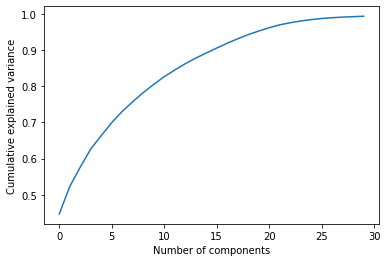

In [ ]:
pca_best_fit = 30

pca = PCA(n_components=pca_best_fit)
pca.fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

X_train_scaled_pca = pca.transform(X_train_scaled)
X_valid_scaled_pca = pca.transform(X_valid_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

X_train_scaled_pca_2d = X_train_scaled_pca.reshape(-1,1,pca_best_fit).astype('float32')
X_valid_scaled_pca_2d = X_valid_scaled_pca.reshape(-1,1,pca_best_fit).astype('float32')
X_test_scaled_pca_2d = X_test_scaled_pca.reshape(-1,1,pca_best_fit).astype('float32')



---



Teste com rede shallow

In [ ]:
model = Sequential()
model.add(Dense(92, activation='tanh', input_shape=(92,)))
model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 92)                8556      
                                                                 
 dense_1 (Dense)             (None, 18)                1674      
                                                                 
Total params: 10,230
Trainable params: 10,230
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model.fit(X_train_scaled, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_valid_scaled, y_valid))

Epoch 1/200
470/470 [==============================] - 2s 3ms/step - loss: 2.6109 - accuracy: 0.1489 - val_loss: 2.4325 - val_accuracy: 0.1997
Epoch 2/200
470/470 [==============================] - 1s 2ms/step - loss: 2.3694 - accuracy: 0.2044 - val_loss: 2.3220 - val_accuracy: 0.2087
Epoch 3/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2978 - accuracy: 0.2250 - val_loss: 2.2674 - val_accuracy: 0.2273
Epoch 4/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2572 - accuracy: 0.2414 - val_loss: 2.2584 - val_accuracy: 0.2467
Epoch 5/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2297 - accuracy: 0.2511 - val_loss: 2.2295 - val_accuracy: 0.2317
Epoch 6/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2069 - accuracy: 0.2627 - val_loss: 2.1852 - val_accuracy: 0.2696
Epoch 7/200
470/470 [==============================] - 1s 2ms/step - loss: 2.1879 - accuracy: 0.2712 - val_loss: 2.2149 - val_accuracy: 0.2692

In [ ]:
model.evaluate(X_test_scaled, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 2ms/step - loss: 1.4712 - accuracy: 0.5338


[1.47124183177948, 0.5338215827941895]

Agora com PCA

In [ ]:
model = Sequential()
model.add(Dense(30, activation='tanh', input_shape=(30,)))
model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 30)                930       
                                                                 
 dense_21 (Dense)            (None, 18)                558       
                                                                 
Total params: 1,488
Trainable params: 1,488
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model.fit(X_train_scaled_pca, y_train, batch_size=128, epochs=200, verbose=1, validation_data=(X_valid_scaled_pca, y_valid))

Epoch 1/200
470/470 [==============================] - 1s 2ms/step - loss: 2.5629 - accuracy: 0.1465 - val_loss: 2.4064 - val_accuracy: 0.1908
Epoch 2/200
470/470 [==============================] - 1s 2ms/step - loss: 2.3641 - accuracy: 0.2029 - val_loss: 2.3207 - val_accuracy: 0.2197
Epoch 3/200
470/470 [==============================] - 1s 2ms/step - loss: 2.3029 - accuracy: 0.2226 - val_loss: 2.2782 - val_accuracy: 0.2244
Epoch 4/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2629 - accuracy: 0.2359 - val_loss: 2.2439 - val_accuracy: 0.2419
Epoch 5/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2325 - accuracy: 0.2539 - val_loss: 2.2192 - val_accuracy: 0.2614
Epoch 6/200
470/470 [==============================] - 1s 2ms/step - loss: 2.2081 - accuracy: 0.2644 - val_loss: 2.1980 - val_accuracy: 0.2638
Epoch 7/200
470/470 [==============================] - 1s 2ms/step - loss: 2.1876 - accuracy: 0.2746 - val_loss: 2.1769 - val_accuracy: 0.2762

In [ ]:
model.evaluate(X_test_scaled_pca, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 7ms/step - loss: 1.7006 - accuracy: 0.4451


[1.7006258964538574, 0.4451398253440857]



---



Teste com Perceprton Multicamada

In [ ]:
model = Sequential()
model.add(Dense(92, activation='relu', input_shape=(92,)))
model.add(Dense(92, activation='relu'))
model.add(Dense(92, activation='relu'))
model.add(Dense(92, activation='relu'))
model.add(Dense(92, activation='relu'))
model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 92)                8556      
                                                                 
 dense_3 (Dense)             (None, 92)                8556      
                                                                 
 dense_4 (Dense)             (None, 92)                8556      
                                                                 
 dense_5 (Dense)             (None, 92)                8556      
                                                                 
 dense_6 (Dense)             (None, 92)                8556      
                                                                 
 dense_7 (Dense)             (None, 18)                1674      
                                                                 
Total params: 44,454
Trainable params: 44,454
Non-trai

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])
model.fit(X_train_scaled, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
470/470 [==============================] - 2s 4ms/step - loss: 0.6650 - accuracy: 0.7768 - val_loss: 1.3628 - val_accuracy: 0.6314
Epoch 2/50
470/470 [==============================] - 2s 3ms/step - loss: 0.6540 - accuracy: 0.7816 - val_loss: 1.4278 - val_accuracy: 0.6338
Epoch 3/50
470/470 [==============================] - 1s 3ms/step - loss: 0.6540 - accuracy: 0.7808 - val_loss: 1.3231 - val_accuracy: 0.6499
Epoch 4/50
470/470 [==============================] - 1s 3ms/step - loss: 0.6571 - accuracy: 0.7818 - val_loss: 1.3578 - val_accuracy: 0.6441
Epoch 5/50
470/470 [==============================] - 1s 3ms/step - loss: 0.6491 - accuracy: 0.7831 - val_loss: 1.4647 - val_accuracy: 0.6224
Epoch 6/50
470/470 [==============================] - 2s 3ms/step - loss: 0.6538 - accuracy: 0.7814 - val_loss: 1.4236 - val_accuracy: 0.6236
Epoch 7/50
470/470 [==============================] - 1s 3ms/step - loss: 0.6450 - accuracy: 0.7846 - val_loss: 1.3189 - val_accuracy: 0.6550
Epoch 

In [ ]:
model.evaluate(X_test_scaled, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 3ms/step - loss: 1.6937 - accuracy: 0.5903


[1.693665623664856, 0.5902796387672424]



---



Teste com CNN

In [ ]:
model = Sequential()
#model.add(Dense(92, activation='tanh', input_shape=(92,)))
model.add(Conv1D(92, kernel_size=(1), activation='relu', input_shape=(1,92)))

model.add(Conv1D(92, kernel_size=(1), activation='relu'))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 1, 92)             8556      
                                                                 
 conv1d_10 (Conv1D)          (None, 1, 92)             8556      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 1, 92)            0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 1, 92)             0         
                                                                 
 flatten_4 (Flatten)         (None, 92)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               11904     
                                                      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled_2d, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_valid_scaled_2d, y_valid))

Epoch 1/50
470/470 [==============================] - 3s 6ms/step - loss: 1.3383 - accuracy: 0.5486 - val_loss: 1.3607 - val_accuracy: 0.5599
Epoch 2/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3306 - accuracy: 0.5532 - val_loss: 1.3128 - val_accuracy: 0.5802
Epoch 3/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3324 - accuracy: 0.5518 - val_loss: 1.3358 - val_accuracy: 0.5678
Epoch 4/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3303 - accuracy: 0.5517 - val_loss: 1.3684 - val_accuracy: 0.5587
Epoch 5/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3225 - accuracy: 0.5547 - val_loss: 1.2934 - val_accuracy: 0.5830
Epoch 6/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3271 - accuracy: 0.5534 - val_loss: 1.2843 - val_accuracy: 0.5832
Epoch 7/50
470/470 [==============================] - 2s 5ms/step - loss: 1.3253 - accuracy: 0.5534 - val_loss: 1.3178 - val_accuracy: 0.5708
Epoch 

In [ ]:
model.evaluate(X_test_scaled_2d, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 1s 11ms/step - loss: 2.8888 - accuracy: 0.0602


[2.888791084289551, 0.060186419636011124]

E com pca

In [ ]:
model = Sequential()
#model.add(Dense(92, activation='tanh', input_shape=(92,)))
model.add(Conv1D(30, kernel_size=(1), activation='relu', input_shape=(1,30)))

model.add(Conv1D(30, kernel_size=(1), activation='relu'))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 1, 30)             930       
                                                                 
 conv1d_12 (Conv1D)          (None, 1, 30)             930       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 30)            0         
 1D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 1, 30)             0         
                                                                 
 flatten_5 (Flatten)         (None, 30)                0         
                                                                 
 dense_22 (Dense)            (None, 128)               3968      
                                                     

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled_pca_2d, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_valid_scaled_pca_2d, y_valid))

Epoch 1/50
470/470 [==============================] - 3s 4ms/step - loss: 2.5057 - accuracy: 0.1492 - val_loss: 2.2205 - val_accuracy: 0.2284
Epoch 2/50
470/470 [==============================] - 2s 4ms/step - loss: 2.2279 - accuracy: 0.2234 - val_loss: 2.0991 - val_accuracy: 0.2819
Epoch 3/50
470/470 [==============================] - 2s 4ms/step - loss: 2.1373 - accuracy: 0.2527 - val_loss: 2.0308 - val_accuracy: 0.3069
Epoch 4/50
470/470 [==============================] - 2s 4ms/step - loss: 2.0821 - accuracy: 0.2767 - val_loss: 1.9729 - val_accuracy: 0.3273
Epoch 5/50
470/470 [==============================] - 2s 4ms/step - loss: 2.0398 - accuracy: 0.2912 - val_loss: 1.9399 - val_accuracy: 0.3395
Epoch 6/50
470/470 [==============================] - 2s 4ms/step - loss: 2.0094 - accuracy: 0.3039 - val_loss: 1.9168 - val_accuracy: 0.3595
Epoch 7/50
470/470 [==============================] - 2s 4ms/step - loss: 1.9834 - accuracy: 0.3174 - val_loss: 1.8817 - val_accuracy: 0.3736
Epoch 

In [ ]:
model.evaluate(X_test_scaled_pca_2d, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 3ms/step - loss: 1.6297 - accuracy: 0.4479


[1.6297285556793213, 0.447936087846756]



---



LSTM Bidirecional

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(92, return_sequences=True),input_shape=(1,92)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(92,return_sequences=True,dropout=0.5, recurrent_dropout=0.5,activation='relu')))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(18, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 1, 184)           136160    
 nal)                                                            
                                                                 
 batch_normalization_7 (Batc  (None, 1, 184)           736       
 hNormalization)                                                 
                                                                 
 bidirectional_5 (Bidirectio  (None, 1, 184)           203872    
 nal)                                                            
                                                                 
 batch_normalization_8 (Batc  (None, 1, 184)           736       
 hNormalization)                                                 
                                                                 
 flatten_10 (Flatten)        (None, 184)             

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train_scaled_2d, y_train, batch_size=201, epochs=100, verbose=1, validation_data=(X_valid_scaled_2d, y_valid))

Epoch 1/100
299/299 [==============================] - 21s 39ms/step - loss: 2.2330 - accuracy: 0.2771 - val_loss: 2.6849 - val_accuracy: 0.1099
Epoch 2/100
299/299 [==============================] - 10s 33ms/step - loss: 1.8460 - accuracy: 0.3886 - val_loss: 1.8642 - val_accuracy: 0.3848
Epoch 3/100
299/299 [==============================] - 10s 33ms/step - loss: 1.7007 - accuracy: 0.4342 - val_loss: 1.7831 - val_accuracy: 0.4220
Epoch 4/100
299/299 [==============================] - 11s 37ms/step - loss: 1.6150 - accuracy: 0.4625 - val_loss: 1.7516 - val_accuracy: 0.4358
Epoch 5/100
299/299 [==============================] - 10s 33ms/step - loss: 1.5524 - accuracy: 0.4834 - val_loss: 1.7458 - val_accuracy: 0.4334
Epoch 6/100
299/299 [==============================] - 10s 33ms/step - loss: 1.5022 - accuracy: 0.4986 - val_loss: 1.9145 - val_accuracy: 0.3993
Epoch 7/100
299/299 [==============================] - 10s 33ms/step - loss: 1.4606 - accuracy: 0.5106 - val_loss: 1.7068 - val_ac

In [ ]:
model.evaluate(X_test_scaled_2d, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 15ms/step - loss: 1.1602 - accuracy: 0.6441


[1.1602237224578857, 0.644074559211731]

CNN+LSTM

In [ ]:
model = Sequential()
#model.add(Dense(92, activation='tanh', input_shape=(92,)))
model.add(Conv1D(92, kernel_size=(1), activation='relu', input_shape=(1,92)))
model.add(MaxPooling1D(pool_size=(1)))
model.add(Conv1D(92, kernel_size=(1), activation='relu'))
model.add(MaxPooling1D(pool_size=(1)))
model.add(LSTM(184))
model.add(BatchNormalization())
#model.add(Dropout(0.5))

#model.add(LSTM(92))
#model.add(BatchNormalization())
#model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(184, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 1, 92)             8556      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 92)            0         
 1D)                                                             
                                                                 
 conv1d_16 (Conv1D)          (None, 1, 92)             8556      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 92)            0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 184)               203872    
                                                                 
 batch_normalization_2 (Batc  (None, 184)            

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(
    X_train_scaled_2d,
    y_train,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_data=(X_valid_scaled_2d, y_valid)
)

Epoch 1/100
470/470 [==============================] - 10s 16ms/step - loss: 2.1773 - accuracy: 0.2703 - val_loss: 2.4212 - val_accuracy: 0.2518
Epoch 2/100
470/470 [==============================] - 7s 15ms/step - loss: 1.8764 - accuracy: 0.3743 - val_loss: 1.8104 - val_accuracy: 0.3908
Epoch 3/100
470/470 [==============================] - 7s 15ms/step - loss: 1.7410 - accuracy: 0.4199 - val_loss: 1.7155 - val_accuracy: 0.4212
Epoch 4/100
470/470 [==============================] - 7s 15ms/step - loss: 1.6673 - accuracy: 0.4433 - val_loss: 1.6897 - val_accuracy: 0.4417
Epoch 5/100
470/470 [==============================] - 7s 15ms/step - loss: 1.6086 - accuracy: 0.4638 - val_loss: 1.7347 - val_accuracy: 0.4306
Epoch 6/100
470/470 [==============================] - 7s 15ms/step - loss: 1.5659 - accuracy: 0.4772 - val_loss: 1.6433 - val_accuracy: 0.4534
Epoch 7/100
470/470 [==============================] - 7s 16ms/step - loss: 1.5269 - accuracy: 0.4941 - val_loss: 1.6004 - val_accuracy

In [ ]:
model.evaluate(X_test_scaled_2d, y_test, batch_size=500, verbose=1)

16/16 [==============================] - 0s 11ms/step - loss: 1.1832 - accuracy: 0.6602


[1.1832314729690552, 0.6601864099502563]



---





---



Provas de conceito

Design neural network architecture

In [ ]:
model = Sequential()

model.add(Bidirectional(LSTM(92, return_sequences=True),input_shape=(1,92)))


model.add(Dense(18, activation='softmax'))

model.summary()

#model.add(Bidirectional(LSTM(92,return_sequences=True,dropout=0.5, recurrent_dropout=0.5,activation='tanh')))
#model.add(BatchNormalization())
#model.add(Bidirectional(LSTM(92,return_sequences=True,activation='tanh')))
#model.add(Bidirectional(LSTM(92,return_sequences=True,dropout=0.5, recurrent_dropout=0.5,activation='tanh')))
#model.add(BatchNormalization())
#model.add(Bidirectional(LSTM(92,return_sequences=True,activation='tanh')))
#model.add(BatchNormalization())
#model.add(Bidirectional(LSTM(92,activation='tanh')))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))
#model.add(Dense(64, activation='relu', input_shape=(784,)))
#model.add(BatchNormalization())

#model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())

#model.add(Dense(64, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.2))

Configure model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['accuracy'])

Train!

In [ ]:
model.fit(X_train_scaled, y_train, batch_size=100, epochs=20, verbose=1, validation_data=(X_valid_scaled, y_valid))

Testing a simpler model

In [ ]:
#model = Sequential()

#model.add(Bidirectional(LSTM(92, return_sequences=True),input_shape=(1,92)))

#model.add(Dense(18, activation='softmax'))

#model.summary()